In [1]:
%load_ext autoreload
%autoreload 2

import cfr
print(cfr.__version__)
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np
from tqdm import tqdm

os.chdir('/glade/u/home/fengzhu/Github/cfr/docsrc/notebooks')

2023.9.14


In [2]:
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')
job.filter_proxydb(by='ptype', keys=['coral'])
job.annualize_proxydb(months=[12, 1, 2], ptypes=['coral'], verbose=True)

>>> job.configs["annualize_proxydb_months"] = [12, 1, 2]
>>> job.configs["annualize_proxydb_ptypes"] = ['coral']


Annualizing ProxyDatabase: 100%|██████████| 104/104 [00:03<00:00, 28.52it/s]

>>> 99 records remaining
>>> job.proxydb updated


In [3]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': 'iCESM_past1000historical/tas',
    },
    anom_period=(1951, 1980),
)

>>> The target file seems existed at: ./data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...


In [4]:
job.annualize_clim(tag='prior', months=[12, 1, 2], verbose=True)
# job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
# job.crop_clim(tag='prior', lat_min=-35, lat_max=35, verbose=True)

>>> job.configs["prior_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.prior updated


In [5]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/air.2m.mon.mean.nc',
    },
    rename_dict={'tas': 'air'},
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/air.2m.mon.mean.nc'}
>>> job.configs["obs_rename_dict"] = {'tas': 'air'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


In [6]:
ptype_psm_dict = {
    'coral.d18O': 'Linear',
    'coral.calc': 'Linear',
    'coral.SrCa': 'Linear',
}
ptype_season_dict = {
    'coral.d18O': [12, 1, 2],  # boreal winter
    'coral.calc': [12, 1, 2],  # boreal winter
    'coral.SrCa': [12, 1, 2],  # boreal winter
}
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    calib_period=(1901, 2000),
    verbose=True,)

>>> job.configs["ptype_psm_dict"] = {'coral.calc': 'Linear', 'coral.d18O': 'Linear', 'coral.SrCa': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'coral.calc': [12, 1, 2], 'coral.d18O': [12, 1, 2], 'coral.SrCa': [12, 1, 2]}
>>> job.configs["psm_calib_period"] = (1901, 2000)


Calibrating the PSMs:  13%|█▎        | 13/99 [00:00<00:04, 20.22it/s]

The number of overlapped data points is 7 < 25. Skipping ...
The number of overlapped data points is 16 < 25. Skipping ...
The number of overlapped data points is 18 < 25. Skipping ...


Calibrating the PSMs:  25%|██▌       | 25/99 [00:01<00:02, 26.60it/s]

The number of overlapped data points is 2 < 25. Skipping ...
The number of overlapped data points is 24 < 25. Skipping ...
The number of overlapped data points is 19 < 25. Skipping ...


Calibrating the PSMs:  54%|█████▎    | 53/99 [00:02<00:01, 28.48it/s]

The number of overlapped data points is 18 < 25. Skipping ...
The number of overlapped data points is 18 < 25. Skipping ...


Calibrating the PSMs:  60%|█████▉    | 59/99 [00:02<00:01, 28.25it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  78%|███████▊  | 77/99 [00:03<00:00, 24.11it/s]

The number of overlapped data points is 17 < 25. Skipping ...


Calibrating the PSMs: 100%|██████████| 99/99 [00:04<00:00, 24.26it/s]

>>> PSM for Ocn_144 failed to be calibrated.
>>> PSM for Ocn_149 failed to be calibrated.
>>> PSM for Ocn_150 failed to be calibrated.
>>> PSM for Ocn_145 failed to be calibrated.
>>> PSM for Ocn_151 failed to be calibrated.
>>> PSM for Ocn_152 failed to be calibrated.
>>> PSM for Ocn_164 failed to be calibrated.
>>> PSM for Ocn_165 failed to be calibrated.
>>> PSM for Ocn_138 failed to be calibrated.
>>> PSM for Ocn_183 failed to be calibrated.
>>> 89 records tagged "calibrated" with ProxyRecord.psm created


In [9]:
sign = {}
for pobj in tqdm(job.proxydb, total=job.proxydb.nrec):
    try:
        sign[pobj.pid] = 1 if pobj.psm.model.params['tas'] >= 0 else -1
    except:
        pass

100%|██████████| 99/99 [00:27<00:00,  3.66it/s]


In [7]:
res = cfr.ReconRes('./recons/lmr-real-pages2k')
res.load(['nino3.4', 'tas'], verbose=True)

target = cfr.ClimateField().fetch('20CRv3/tas', vn='air').rename('tas').get_anom((1951, 1980))
target = target.annualize(months=[12, 1, 2]).crop(lat_min=-35, lat_max=35)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> The target file seems existed at: ./data/air.2m.mon.mean.nc . Loading from it instead of downloading ...


In [8]:
stat = 'corr'

valid_fd = res.recons['tas'].compare(
    target, stat=stat,
    timespan=(1874, 2000),
)

-0.5726767134888835


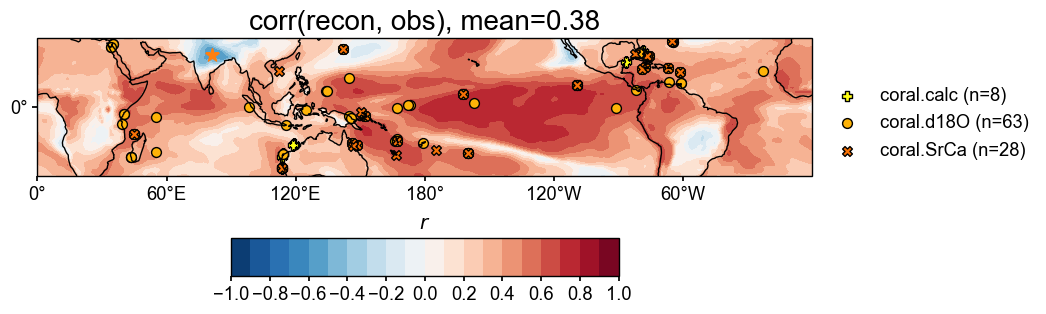

In [9]:
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fd.plot(
    title=f'{stat}(recon, obs), mean={valid_fd.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=True, plot_proxydb=True, plot_proxydb_lgd=True, proxydb=job.proxydb,
    proxydb_lgd_kws={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
)

check_lat, check_lon = 24, 81
ax.scatter(check_lon, check_lat, marker='*', c='tab:orange', s=100, transform=ccrs.PlateCarree())
print(valid_fd.da.sel(lat=check_lat, lon=check_lon).values[0])

In [10]:
target_ts = target.da.sel(lat=check_lat, lon=check_lon)
prior_ts = job.prior['tas'].da.sel(lat=check_lat, lon=check_lon, method='nearest')

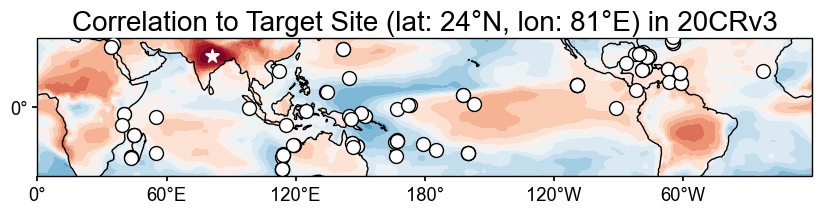

Figure saved at: "figs/check_spatial_top.pdf"


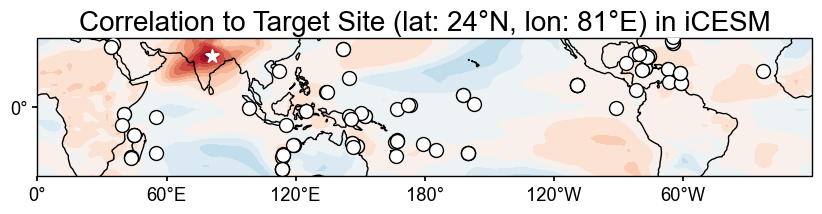

Figure saved at: "figs/check_spatial_middle.pdf"


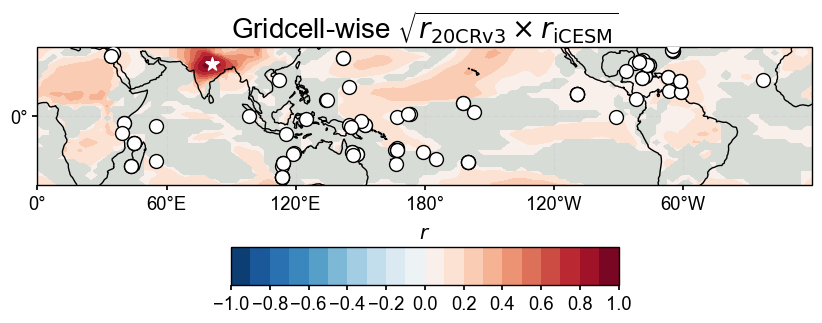

Figure saved at: "figs/check_spatial_bottom.pdf"


In [11]:
stat_da_obs = xr.corr(target.da, target_ts.sel(time=slice(1874, 2000)), dim='time').expand_dims({'time': [1]})
stat_da_obs.name = 'corr'
stat_fd_obs = cfr.ClimateField(stat_da_obs)
stat_fd_obs.plot_kwargs = {
    'cmap': 'RdBu_r',
    'extend': 'neither',
    'levels': np.linspace(-1, 1, 21),
    'cbar_labels': np.linspace(-1, 1, 11),
    'cbar_title': r'$r$',
    'cbar_title_y': 1,
    'cbar_orientation': 'horizontal',
    'cbar_pad': 0.1,
}

stat_da_prior = xr.corr(job.prior['tas'].da, prior_ts.sel(time=slice(1874, 2000)), dim='time').expand_dims({'time': [1]})
stat_da_prior.name = 'corr'
stat_fd_prior = cfr.ClimateField(stat_da_prior)
stat_fd_prior.plot_kwargs = {
    'cmap': 'RdBu_r',
    'extend': 'neither',
    'levels': np.linspace(-1, 1, 21),
    'cbar_labels': np.linspace(-1, 1, 11),
    'cbar_title': r'$r$',
    'cbar_title_y': 1,
    'cbar_orientation': 'horizontal',
    'cbar_pad': 0.1,
}

fig, ax = stat_fd_obs.plot(
    projection='PlateCarree',
    central_longitude=180,
    # add_cyclic_point=False,
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
    title= r'Correlation to Target Site (lat: 24°N, lon: 81°E) in 20CRv3'
)
ax.scatter(check_lon, check_lat, marker='*', c='white', s=100, transform=ccrs.PlateCarree())
ax.scatter(job.proxydb.lons, job.proxydb.lats, marker='o', c='white', edgecolor='k', s=100, transform=ccrs.PlateCarree(), zorder=99)
cfr.visual.showfig(fig)
cfr.visual.savefig(fig, 'figs/check_spatial_top.pdf')

fig, ax = stat_fd_prior.plot(
    projection='PlateCarree',
    central_longitude=180,
    # add_cyclic_point=False,
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
    title= r'Correlation to Target Site (lat: 24°N, lon: 81°E) in iCESM'
)
ax.scatter(check_lon, check_lat, marker='*', c='white', s=100, transform=ccrs.PlateCarree())
ax.scatter(job.proxydb.lons, job.proxydb.lats, marker='o', c='white', edgecolor='k', s=100, transform=ccrs.PlateCarree(), zorder=99)
cfr.visual.showfig(fig)
cfr.visual.savefig(fig, 'figs/check_spatial_middle.pdf')

stat_fd = stat_fd_prior.copy()
# stat_fd.da = stat_fd_prior.regrid(stat_fd_obs.da.lat, stat_fd_obs.da.lon).da * stat_fd_obs.da
stat_fd.da = np.sqrt(stat_fd_prior.da * stat_fd_obs.regrid(stat_fd_prior.da.lat, stat_fd_prior.da.lon).da)

fig, ax = stat_fd.plot(
    projection='PlateCarree',
    central_longitude=180,
    # add_cyclic_point=False,
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=True,
    title= r'Gridcell-wise $\sqrt{r_\text{20CRv3}\times r_\text{iCESM}}$'
)
ax.scatter(check_lon, check_lat, marker='*', c='white', s=100, transform=ccrs.PlateCarree())
ax.scatter(job.proxydb.lons, job.proxydb.lats, marker='o', c='white', edgecolor='k', s=100, transform=ccrs.PlateCarree(), zorder=99)
cfr.visual.showfig(fig)
cfr.visual.savefig(fig, 'figs/check_spatial_bottom.pdf')

In [22]:
corr_proxy_target = {}
for pobj in tqdm(job.proxydb, total=job.proxydb.nrec):
    try:
        pobj_da = pobj['1874':'2000'].to_da()
        pobj_da['time'] = [int(t) for t in cfr.utils.datetime2year_float(pobj_da.time.values)]
        corr_proxy_target[pobj.pid] = xr.corr(pobj_da * sign[pobj.pid], target_ts.sel(time=slice(1874, 2000)), dim='time')
    except:
        pass

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:28<00:00,  3.51it/s]


In [23]:
corrs = []
lats = []
lons = []
for k, v in corr_proxy_target.items():
    corrs.append(v)
    lats.append(job.proxydb[k].lat)
    lons.append(job.proxydb[k].lon)

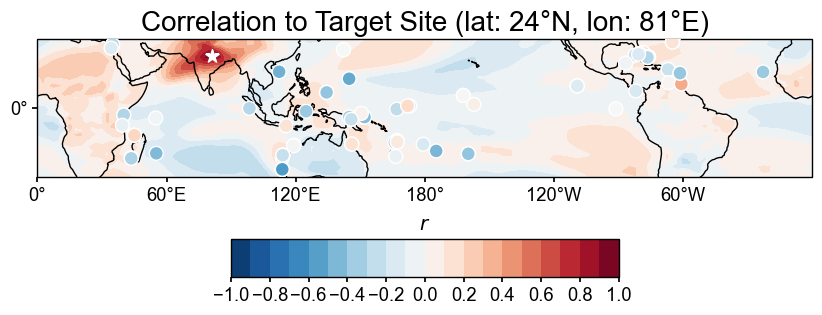

Figure saved at: "check_spatial.pdf"


In [277]:
fig, ax = stat_fd_prior.plot(
    projection='PlateCarree',
    central_longitude=180,
    # add_cyclic_point=False,
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=True,
    title= r'Correlation to Target Site (lat: 24°N, lon: 81°E)'
)
ax.scatter(check_lon, check_lat, marker='*', c='white', s=100, transform=ccrs.PlateCarree())
cfr.visual.plot_scatter_map(
    corrs, lats, lons, ms=100,
    vmin=-1, vmax=1, cmap='RdBu_r',
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
    ax=ax, fig=fig, gridlines=False,
)
cfr.visual.showfig(fig)
cfr.visual.savefig(fig, 'check_spatial.pdf')

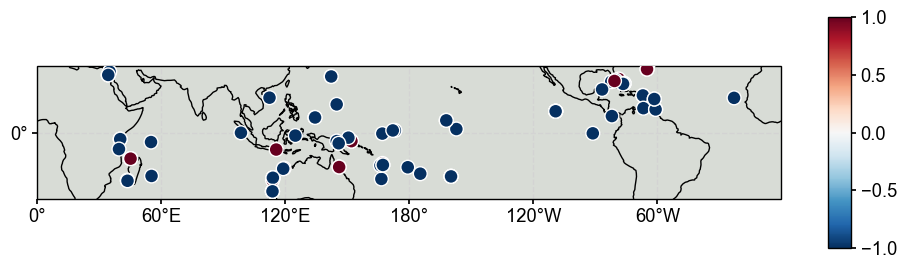

In [283]:
fig, ax = cfr.visual.plot_scatter_map(
    [v for k, v in sign.items()], lats, lons, ms=100,
    vmin=-1, vmax=1, cmap='RdBu_r',
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=True,
    gridlines=False,
    projection='PlateCarree',
    stock_img=False,
)